In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import tensorflow_datasets as tfds

import math
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)
tf.logging.set_verbosity(tf.logging.ERROR)
tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

1.13.1


# import Fashion MNIST dataset

In [2]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Num of training examples:", num_train_examples)
print("Num of test examples:", num_test_examples)

Num of training examples: 60000
Num of test examples: 10000


In [5]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

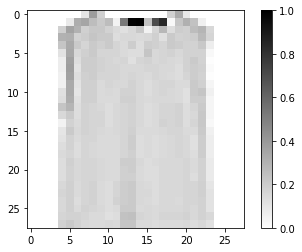

In [6]:
for image, label in train_dataset.take(1):
    break
image = image.numpy().reshape((28, 28))

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

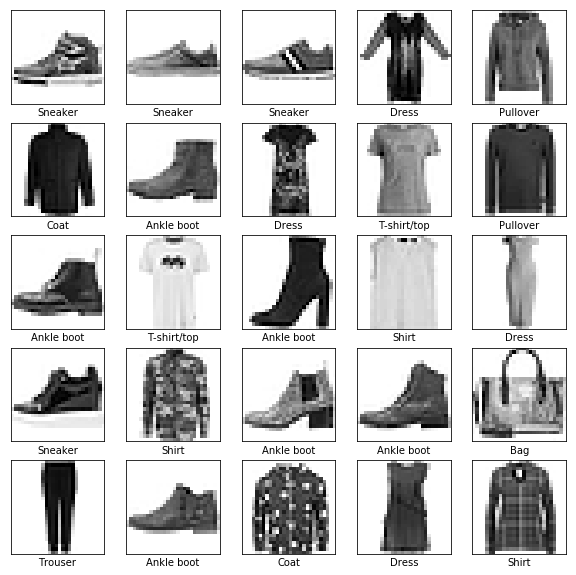

In [7]:
plt.figure(figsize=(10, 10))
i = 1
for (image, label) in train_dataset.take(25):
    image = image.numpy().reshape((28, 28))
    plt.subplot(5, 5, i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

# Built the model

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.3865 - acc: 0.8607
Epoch 2/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.2592 - acc: 0.9055
Epoch 3/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.2108 - acc: 0.9233
Epoch 4/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1769 - acc: 0.9347
Epoch 5/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1542 - acc: 0.9427
Epoch 6/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.1307 - acc: 0.9527
Epoch 7/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1074 - acc: 0.9600
Epoch 8/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0901 - acc: 0.9676
Epoch 9/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0761 - acc: 0.9713
Epoch 10/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0636 - acc: 0.9771


In [11]:
# evaluate
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print("Accuracy on test dataset:", test_accuracy)

313/313 [==============================] - 2s 6ms/step - loss: 0.3036 - acc: 0.9239
Accuracy on test dataset: 0.9239


In [12]:
# make predictions and explore
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)
    
print(predictions.shape)

(32, 10)


In [13]:
predictions[0]

array([3.3736562e-09, 8.6073523e-11, 3.1102854e-07, 7.8081719e-10,
       5.2595314e-02, 1.4362793e-13, 9.4740433e-01, 1.6236280e-15,
       3.3363652e-11, 4.8396186e-11], dtype=float32)

In [14]:
np.argmax(predictions[0])

6

In [15]:
test_labels[0]

6

In [16]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img[..., 0], cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
               color=color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

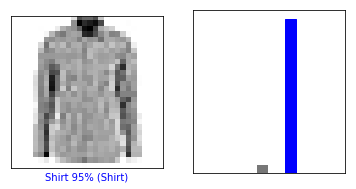

In [17]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

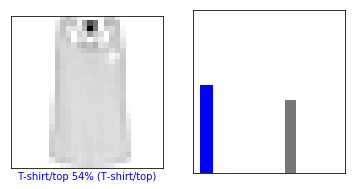

In [18]:
i = 2
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)